# ARIMA

**Assumptions:**
- Stationary time series
    - If it's not do differences until it is

In [71]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import itertools # using the product for the cartesian product
import pandas as pd
import numpy as np
import random
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm
import json

import warnings
warnings.filterwarnings('ignore')

### Object

In [72]:
# essentially https://goldinlocks.github.io/Time-Series-Cross-Validation/
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits: int = 5, val_size: float = 0.2):
        self.n_splits = n_splits
        self.val_size = val_size

    def split(self, X, y=None):
        block_size = len(X) // self.n_splits
        indices = np.arange(len(X))
        for i in range(self.n_splits):
            start = i * block_size
            stop = start + block_size
            split = stop - int(self.val_size * (stop-start))
            yield indices[start:split], indices[split:stop]

### Helper Functions

In [73]:
def plot_forecasts(df: pd.DataFrame, pred: pd.Series, s: int):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df.date,
        y=df.consumption,
        mode='lines',
        name='Actual'
    ))
    
    fig.add_trace(go.Scatter(
        x=df.loc[s:, 'date'],
        y=pred,
        mode='lines',
        name='Forecasted'
    ))
    
    fig.update_layout(
        title="Actual vs Forecasted Values for Consumption",
        xaxis_title="Date",
        yaxis_title="Consumption (MWh)",
        legend_title="Legend"
    )
    fig.show()

In [74]:
def create_corr_plot(series, lags=None, plot_pacf=False):
    # from https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/3
    corr_array = pacf(series.dropna(), nlags=lags, alpha=0.05) if plot_pacf else acf(series.dropna(), nlags=lags, alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=8)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_yaxes(zerolinecolor='#000000', range=[-1, 1])
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

In [75]:
def plot_forecast_cv():
    pass

## Prepare the Data

Due to us using demand as a proxy for consumption it will have to be dropped as a feature.

Everything else will either have to be dropped if there is less that 90% non-nan values. Everything else will be backward filled and forward filled.

In [76]:
data = pd.read_csv("../../../data/dataset.csv", parse_dates=['date'])
thresh = int(0.9 * len(data))
data = data.dropna(axis=1, thresh=thresh).bfill().ffill().drop('demand', axis=1)
# data

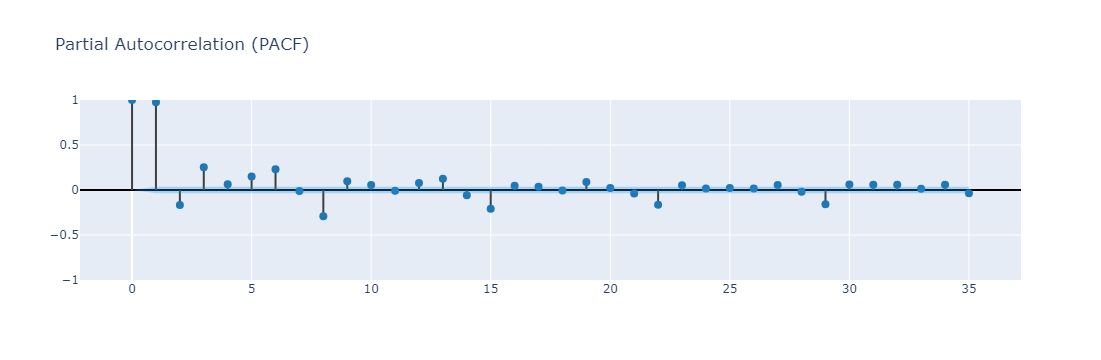

In [77]:
create_corr_plot(data.consumption, None, True)

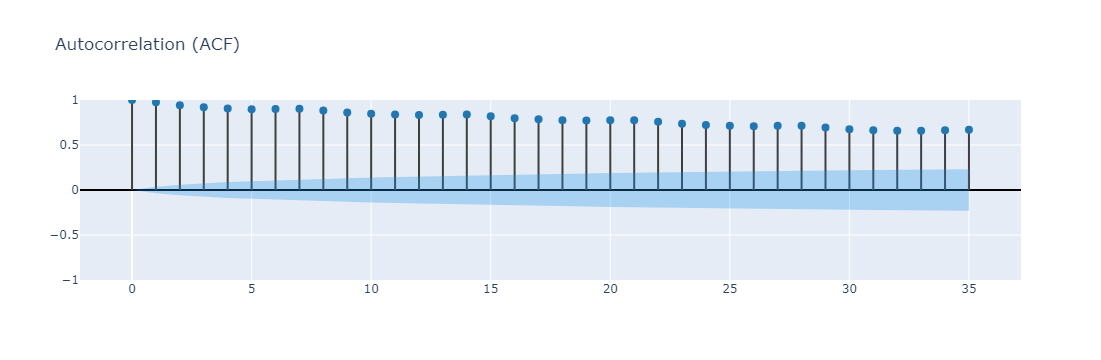

In [78]:
create_corr_plot(data.consumption, None, False)

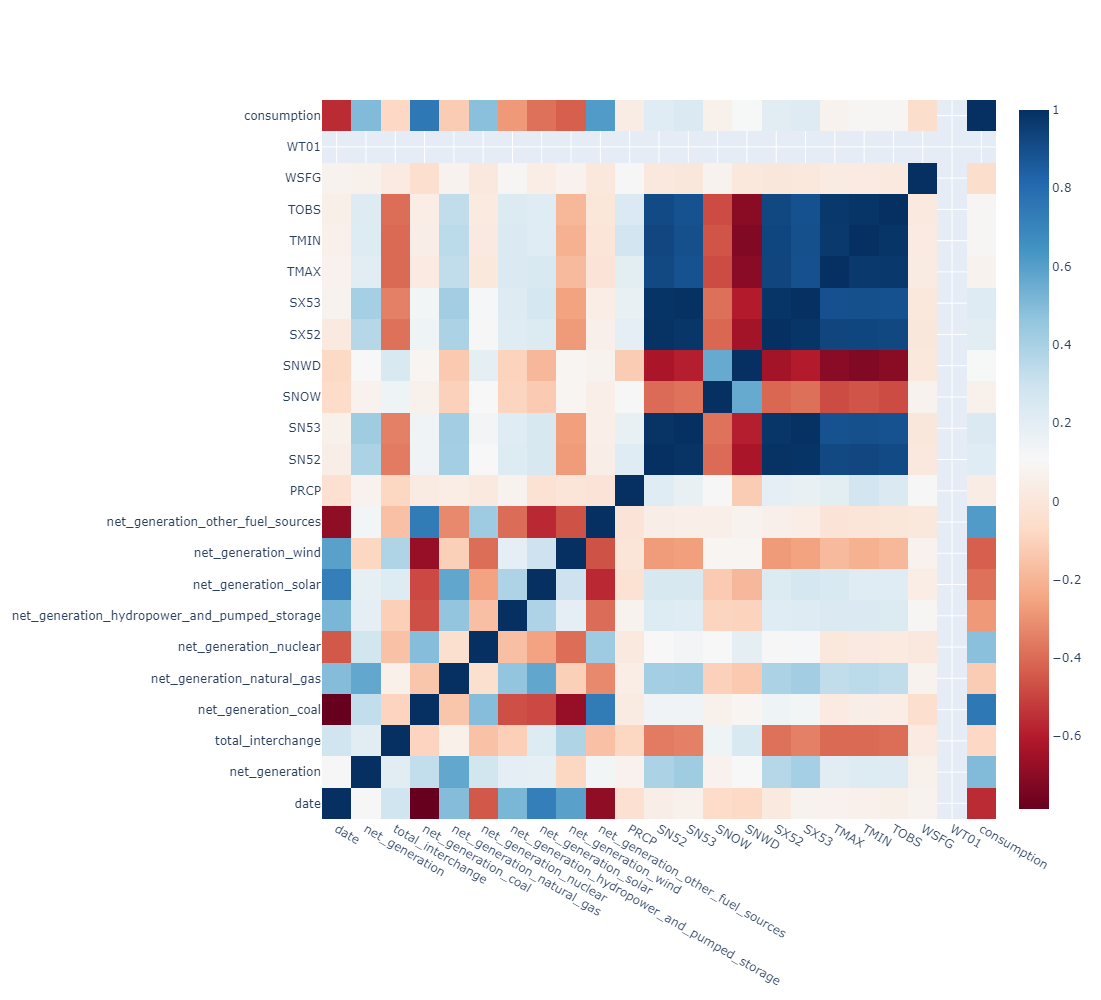

In [79]:
corr_matrix = data.corr()
go.Figure(go.Heatmap(
    z=corr_matrix,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale=px.colors.diverging.RdBu
)).update_layout(
    width=1000,
    height=1000
)

## Splits

In [80]:
data.shape

(3184, 23)

In [81]:
data.date.min(), data.date.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2024-09-18 00:00:00'))

In [82]:
split = int(len(data) * 0.85)
train, test = data.iloc[:split, :], data.iloc[split:, :]
endog_train, exog_train = train['consumption'], train.drop(['date', 'consumption'], axis=1)
endog_test, exog_test = test['consumption'], test.drop(['date', 'consumption'], axis=1)

## Training a Baseline

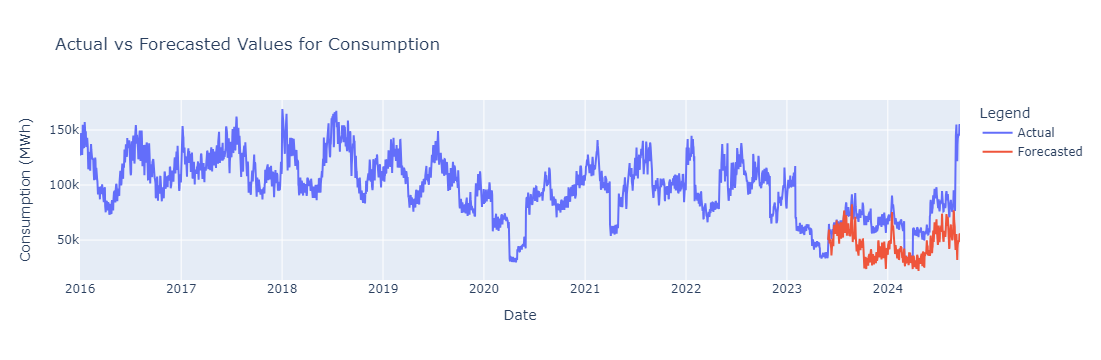

In [83]:
order = (0, 1, 0)
baseline = ARIMA(endog_train, exog_train.astype(float), order=order).fit()
predictions = baseline.forecast(steps=len(endog_test), exog=exog_test)
plot_forecasts(data, predictions, split)

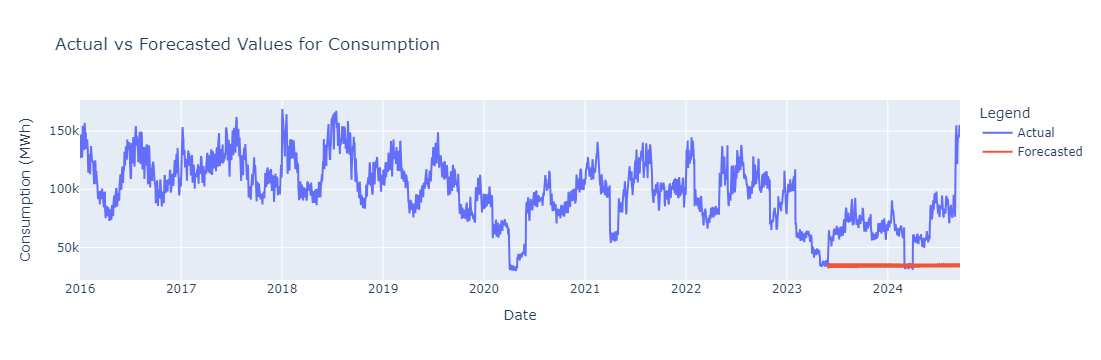

In [89]:
order = (5, 1, 2)
baseline_ = ARIMA(endog_train, order=order).fit()
predictions = baseline_.forecast(steps=len(endog_test))
plot_forecasts(data, predictions, split)

In [14]:
baseline.save("../../models/ARIMA_baseline.pickle")

## Hyper-Parameter Tuning and Cross Validation

SKlearn can't really help us here so how will we do cross validation?

Cross validation in Sklearn is using the k-1 folds for training and a hold out set, we are using blocked CV, so we will be averaging our holdout in each CV (the future for each CV). There will be no overlapping between blocks so we don't worry about that. We have an untouched test set which we will see at the end when we compare our top 3 ARIMA models. For comparability I think mean squared error is the best choice.

In [15]:
btss = BlockingTimeSeriesSplit(n_splits=4, val_size=0.2)
n_samples = 100

p = range(0, 10)
q = range(0, 10)
d = range(0, 6)
search_space = list(itertools.product(p, q, d))
random_search_space = random.sample(search_space, n_samples)

searched_params = [None]
avg_mses = [np.inf]

for ods in tqdm(random_search_space):
    searched_params.append(ods) # params searched already, we will use the above to argmin this
    mses = []
    for i, (x, y) in enumerate(btss.split(train)):
        endog_train = train.loc[x, 'consumption'].reset_index(drop=True)
        exog_train = train.loc[x].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
        endog_val = train.loc[y, 'consumption'].reset_index(drop=True)
        exog_val = train.loc[y].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
        model = SARIMAX(endog_train, exog_train.astype(float), order=ods).fit(method='bfgs', disp=False)
        predictions = model.forecast(steps=len(endog_val), exog=exog_val)
        
        mses.append(mean_squared_error(endog_val, predictions))
    avg_mses.append(np.mean(mses)) # average mean squared error loss across the blocks, the lowest will be here

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [21:03<00:00, 12.64s/it]


In [45]:
idxs = np.argsort(avg_mses)[:3]
with open("ARIMA_top3.json", "w") as f:
    json.dump([searched_params[i] for i in idxs], f)

## Evaluation

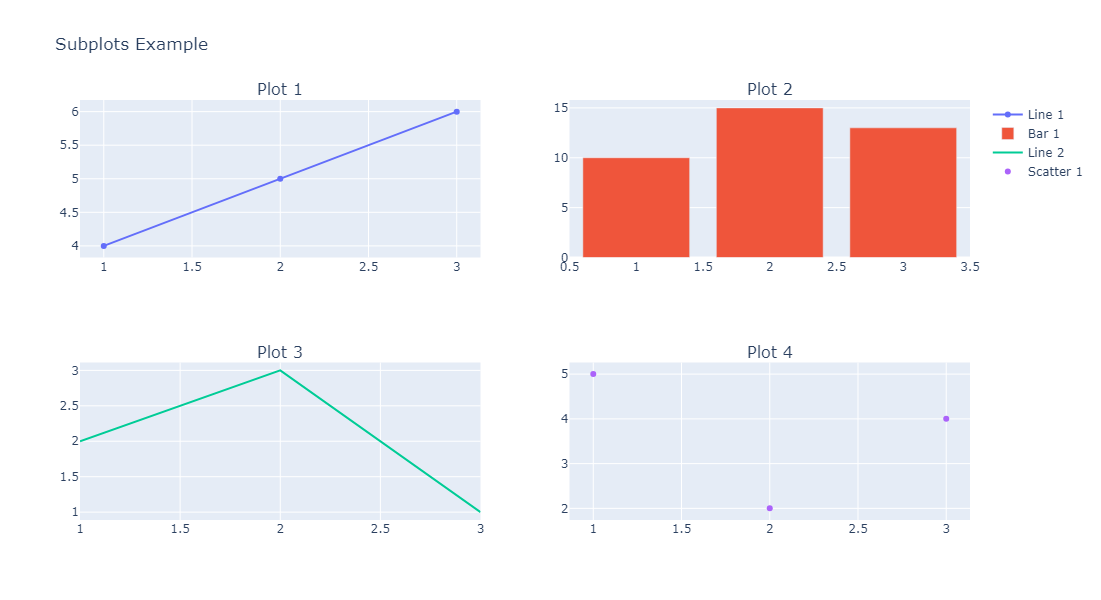

In [43]:
# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

# Add traces to each subplot
# Plot 1
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], mode='lines+markers', name='Line 1'), row=1, col=1)

# Plot 2
fig.add_trace(go.Bar(x=[1, 2, 3], y=[10, 15, 13], name='Bar 1'), row=1, col=2)

# Plot 3
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[2, 3, 1], mode='lines', name='Line 2'), row=2, col=1)

# Plot 4
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[5, 2, 4], mode='markers', name='Scatter 1'), row=2, col=2)

# Update layout
fig.update_layout(title_text="Subplots Example", height=600, width=800)

# Show the plot
fig.show()

In [ ]:
# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

# Add traces to each subplot
# Plot 1
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], mode='lines+markers', name='Line 1'), row=1, col=1)

# Plot 2
fig.add_trace(go.Bar(x=[1, 2, 3], y=[10, 15, 13], name='Bar 1'), row=1, col=2)

# Plot 3
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[2, 3, 1], mode='lines', name='Line 2'), row=2, col=1)

# Plot 4
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[5, 2, 4], mode='markers', name='Scatter 1'), row=2, col=2)

# Update layout
fig.update_layout(title_text="Subplots Example", height=600, width=800)

# Show the plot
fig.show()